In [ ]:
pip install mediapipe opencv-python numpy tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
SEQUENCE_LENGTH = 25

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(SEQUENCE_LENGTH, 63)),
    LSTM(64, return_sequences=False, activation='relu'),  # Only last output is taken
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Single output for the sequence
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 64)              │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,857 (257.25 KB)

 Trainable params: 65,857 (257.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.1)

# Paths
FRAMES_DIR = "/content/sample_data/frames"
OUTPUT_DIR = "/content/sample_data/dataset"
SEQUENCE_LENGTH = 25
NUM_LANDMARKS = 42 * 3  # 21 keypoints * 2 hands * (x, y, z)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

gesture_labels = {"Y": 0, "H": 1, "J": 2}

def extract_landmarks(image_path):
    """Extract hand landmarks relative to wrist midpoint."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    left_hand, right_hand = None, None
    all_landmarks = []

    if results.multi_hand_landmarks:
        detected_hands = []

        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            detected_hands.append((landmarks, handedness.classification[0].label))  # 'Left' or 'Right'

        # Assign left and right hands correctly
        left_hand = next((l for l, h in detected_hands if h == "Left"), None)
        right_hand = next((l for l, h in detected_hands if h == "Right"), None)

    # Find wrist midpoint
    if left_hand is not None and right_hand is not None:
        wrist_midpoint = (left_hand[0] + right_hand[0]) / 2  # Average of both wrists
    elif left_hand is not None:
        wrist_midpoint = left_hand[0]  # Use left wrist if only one hand
    elif right_hand is not None:
        wrist_midpoint = right_hand[0]  # Use right wrist if only one hand
    else:
        wrist_midpoint = np.zeros(3)  # No hand detected, use (0,0,0)

    # Normalize landmarks relative to wrist midpoint
    if left_hand is not None:
        left_hand -= wrist_midpoint
        all_landmarks.extend(left_hand.flatten())
    if right_hand is not None:
        right_hand -= wrist_midpoint
        all_landmarks.extend(right_hand.flatten())

    # Pad missing hand landmarks with zeros
    while len(all_landmarks) < NUM_LANDMARKS:
        all_landmarks.extend([0] * 3 * 21)

    return all_landmarks


def process_gesture_folder(gesture_folder, label):
    """Extract sequences from gesture folder."""
    frame_files = sorted(os.listdir(gesture_folder))
    X_data, Y_data = [], []

    if len(frame_files) < SEQUENCE_LENGTH:
        return np.array([]), np.array([])

    # Extract strictly non-overlapping sequences
    for i in range(0, len(frame_files) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
        sequence = []
        for j in range(SEQUENCE_LENGTH):
            frame_path = os.path.join(gesture_folder, frame_files[i + j])
            landmarks = extract_landmarks(frame_path)
            sequence.append(landmarks)

        X_data.append(sequence)
        Y_data.append(label)

    return np.array(X_data), np.array(Y_data)

# Prepare dataset
X_dataset, Y_dataset = [], []

for gesture, label in gesture_labels.items():
    gesture_folder = os.path.join(FRAMES_DIR, gesture)
    X, Y = process_gesture_folder(gesture_folder, label)
    if X.size > 0:
        X_dataset.append(X)
        Y_dataset.append(Y)

X_dataset = np.concatenate(X_dataset, axis=0)
Y_dataset = np.concatenate(Y_dataset, axis=0)

np.save(os.path.join(OUTPUT_DIR, "X_data.npy"), X_dataset)
np.save(os.path.join(OUTPUT_DIR, "Y_data.npy"), Y_dataset)

print(f"✅ Dataset saved! Shape: X={X_dataset.shape}, Y={Y_dataset.shape}")


✅ Dataset saved! Shape: X=(54, 25, 126), Y=(54,)


In [ ]:
Y_dataset

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

def draw_landmarks_on_image(image_path):
    """Detects hand landmarks and overlays them on the image."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MediaPipe
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks and connections
            mp_drawing.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display the image with landmarks
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Hand Landmarks Overlay")
    plt.show()

# Example usage
sample_image_path = "/content/sample_data/frames/J/frame00050.jpg"  # Update with actual path
# image = cv2.resize(sample_image_path, (640, 480))
draw_landmarks_on_image(sample_image_path)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load dataset
X = np.load("/content/sample_data/dataset/X_data.npy")  # Shape: (20, 15, 126)
Y = np.load("/content/sample_data/dataset/Y_data.npy")  # Shape: (20,)

# Normalize X (already between 0-1, but can standardize if needed)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# One-hot encode Y
num_classes = len(set(Y))  # Number of unique gestures
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")


✅ Preprocessed Data Shapes -> X_train: (43, 25, 126), Y_train: (43, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Model Parameters
sequence_length = 25  # 15 frames per sequence
num_features = 126    # 42 landmarks * 3 (x, y, z)
hidden_units = 64     # LSTM hidden state size

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(hidden_units, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 25, 64)              │          48,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,611 (330.51 KB)

 Trainable params: 84,355 (329.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
Y_val

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:

# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - accuracy: 0.3108 - loss: 1.8676 - val_accuracy: 0.3636 - val_loss: 1.0698
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6633 - loss: 0.6853 - val_accuracy: 0.3636 - val_loss: 1.0468
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8912 - loss: 0.2522 - val_accuracy: 0.3636 - val_loss: 1.0247
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9482 - loss: 0.1805 - val_accuracy: 0.5455 - val_loss: 1.0084
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9482 - loss: 0.1733 - val_accuracy: 0.5455 - val_loss: 0.9870
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9845 - loss: 0.0950 - val_accuracy: 0.5455 - val_loss: 0.9664
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9380 - loss: 0.1571 - val_accuracy: 0.7273 - val_loss: 0.9459
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.0916 - val_accuracy: 0.9091 - val_loss:

In [ ]:
Y_predicted = np.argmax(model.predict(X_val), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
Y_predicted

array([1, 2, 2, 0, 2, 0, 0, 2, 0, 1, 0])

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque
from google.colab.patches import cv2_imshow

# Load trained LSTM model


# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Video path
VIDEO_PATH = "/content/sample_data/test/J_2.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)

# Parameters
SEQUENCE_LENGTH = 25  # Same as during training
NUM_LANDMARKS = 42 * 3  # 42 keypoints (21 per hand) * 3 (x, y, z)

# Class labels (update according to your dataset)
gesture_labels = {0: "Y", 1: "H", 2: "J"}  # Update with actual labels

# Define frame indices for the three sequences
sequence_indices = [
    0,                          # First sequence (frames 0-24)
    (total_frames // 2) - 12,   # Middle sequence (centered around the middle)
    total_frames - SEQUENCE_LENGTH  # Last sequence (frames at the end)
]
sequence_indices = [max(0, min(idx, total_frames - SEQUENCE_LENGTH)) for idx in sequence_indices]  # Ensure valid indices


# Get total frame count
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Function to extract landmarks
def extract_landmarks(frame):
    """Extracts hand landmarks relative to the wrist midpoint."""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    left_hand, right_hand = None, None
    all_landmarks = []

    if results.multi_hand_landmarks:
        detected_hands = []

        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            detected_hands.append((landmarks, handedness.classification[0].label))  # 'Left' or 'Right'

        # Assign left and right hands correctly
        left_hand = next((l for l, h in detected_hands if h == "Left"), None)
        right_hand = next((l for l, h in detected_hands if h == "Right"), None)

    # Find wrist midpoint
    if left_hand is not None and right_hand is not None:
        wrist_midpoint = (left_hand[0] + right_hand[0]) / 2  # Average of both wrists
    elif left_hand is not None:
        wrist_midpoint = left_hand[0]  # Use left wrist if only one hand
    elif right_hand is not None:
        wrist_midpoint = right_hand[0]  # Use right wrist if only one hand
    else:
        wrist_midpoint = np.zeros(3)  # No hand detected, use (0,0,0)

    # Normalize landmarks relative to wrist midpoint
    if left_hand is not None:
        left_hand -= wrist_midpoint
        all_landmarks.extend(left_hand.flatten())
    if right_hand is not None:
        right_hand -= wrist_midpoint
        all_landmarks.extend(right_hand.flatten())

    # Pad missing hand landmarks with zeros
    while len(all_landmarks) < NUM_LANDMARKS:
        all_landmarks.extend([0] * 3 * 21)

    return np.array(all_landmarks)

# Store predictions
predictions = []
# Process video
# Process video for the three sequences
for seq_start in sequence_indices:
    sequence_buffer = []

    # Seek to the sequence start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, seq_start)

    # Read 25 frames
    for _ in range(SEQUENCE_LENGTH):
        ret, frame = cap.read()
        if not ret:
            break
        landmarks = extract_landmarks(frame)
        sequence_buffer.append(landmarks)

    # Convert to NumPy and predict
    if len(sequence_buffer) == SEQUENCE_LENGTH:
        input_sequence = np.expand_dims(np.array(sequence_buffer), axis=0)  # Shape: (1, 25, 126)
        input_sequence = (input_sequence - np.min(input_sequence)) / (np.max(input_sequence) - np.min(input_sequence))
        prediction = model.predict(input_sequence)
        predicted_class = np.argmax(prediction)
        predictions.append(gesture_labels.get(predicted_class, "Unknown"))

# Release video
cap.release()
cv2.destroyAllWindows()

# Display final predictions
for i, pred in enumerate(predictions):
    print(f"Prediction {i+1}: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction 1: J
Prediction 2: J
Prediction 3: J


# 26 Letters Classification

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load dataset
X = np.load("/content/X_data.npy")  # Shape: (20, 15, 126)
Y = np.load("/content/Y_data.npy")  # Shape: (20,)

# Normalize X (already between 0-1, but can standardize if needed)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# One-hot encode Y
num_classes = len(set(Y))  # Number of unique gestures
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

✅ Preprocessed Data Shapes -> X_train: (228, 25, 126), Y_train: (228, 26)


array([[[0.37536773, 0.49811478, 0.50263583, ..., 0.64961891,
         0.47170119, 0.46692846],
        [0.37501746, 0.49783204, 0.50263583, ..., 0.65001245,
         0.47117539, 0.46792102],
        [0.3752563 , 0.49782602, 0.50263582, ..., 0.65211316,
         0.47121818, 0.46765022],
        ...,
        [0.37465511, 0.49810867, 0.50263585, ..., 0.64783645,
         0.47118497, 0.46464174],
        [0.37439062, 0.49813885, 0.50263584, ..., 0.64774354,
         0.47153428, 0.46416497],
        [0.37350121, 0.49843268, 0.50263583, ..., 0.6477035 ,
         0.47173651, 0.46421093]],

       [[0.46293624, 0.41974403, 0.50263568, ..., 0.55127555,
         0.57097059, 0.47885058],
        [0.46290085, 0.42003788, 0.50263567, ..., 0.55159499,
         0.56890942, 0.47891715],
        [0.46311037, 0.41962012, 0.50263568, ..., 0.55136259,
         0.57135966, 0.47735928],
        ...,
        [0.45842628, 0.37707532, 0.50263571, ..., 0.52992324,
         0.62496248, 0.47077287],
        [0.4

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Model Parameters
sequence_length = 25  # Number of frames per sequence
num_features = 126    # 42 landmarks * 3 (x, y, z)
hidden_units = 128    # Increased hidden size for better feature extraction
num_classes = 26      # A to Z
l2_lambda = 0.001

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    # LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation="relu"),
    # Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 25, 128)             │         130,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 273,114 (1.04 MB)

 Trainable params: 272,602 (1.04 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.0578 - loss: 4.9670 - val_accuracy: 0.0517 - val_loss: 3.7273
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.0873 - loss: 4.0638 - val_accuracy: 0.0517 - val_loss: 3.7269
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1845 - loss: 3.4525 - val_accuracy: 0.0345 - val_loss: 3.7268
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2155 - loss: 3.1924 - val_accuracy: 0.0000e+00 - val_loss: 3.7274
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3562 - loss: 2.8855 - val_accuracy: 0.0690 - val_loss: 3.7108
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3835 - loss: 2.6078 - val_accuracy: 0.0345 - val_loss: 3.7225
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4235 - loss: 2.4072 - val_accuracy: 0.0172 - val_loss: 3.7447
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.4347 - loss: 2.3365 - val_accuracy: 0.0690 - 

KeyboardInterrupt: 

# For Double handed Data

In [42]:
import pandas as pd
import numpy as np

def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 1:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double Handed Gestures 20th March.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)


X shape: (189, 25, 84)
Y shape: (189,)


In [43]:
Y_seq

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'D', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E',
       'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'Q', 'Q',
       'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'X', 'X', 'X', 'X',
       'X', 'X', 'X', 'X', 'X', 'X', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Z

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

✅ Preprocessed Data Shapes -> X_train: (151, 25, 84), Y_train: (151, 18)


In [45]:
Y_seq

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [46]:
print(f"✅ Preprocessed Data Shapes -> X_test: {X_val.shape}, Y_test: {Y_val.shape}")

✅ Preprocessed Data Shapes -> X_test: (38, 25, 84), Y_test: (38, 18)


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Model Parameters
sequence_length = 25  # Number of frames per sequence
num_features = 84    # 42 landmarks * 3 (x, y, z)
hidden_units = 128    # Increased hidden size for better feature extraction
num_classes = 18     # A to Z
l2_lambda = 0.001

# Build LSTM Model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(sequence_length, num_features), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Dropout(0.5),

    # LSTM(hidden_units, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda)),
    # BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation="relu"),
    # Dropout(0.3),

    Dense(num_classes, activation="softmax")  # Output layer
])

# Compile Model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 25, 128)             │         109,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,090 (980.82 KB)

 Trainable params: 250,578 (978.82 KB)

 Non-trainable params: 512 (2.00 KB)

In [48]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Number of training cycles
    batch_size=32,
    verbose=1
)
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.0542 - loss: 4.3251 - val_accuracy: 0.2632 - val_loss: 3.1907
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.2341 - loss: 2.9754 - val_accuracy: 0.3684 - val_loss: 3.0812
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3245 - loss: 2.4167 - val_accuracy: 0.5000 - val_loss: 3.0073
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4598 - loss: 2.0572 - val_accuracy: 0.6316 - val_loss: 2.8918
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5979 - loss: 1.8134 - val_accuracy: 0.6842 - val_loss: 2.7810
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5998 - loss: 1.6021 - val_accuracy: 0.5000 - val_loss: 2.6871
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7061 - loss: 1.4414 - val_accuracy: 0.6053 - val_loss: 2.5937
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6770 - loss: 1.4134 - val_accuracy: 0.7368 - val_l

In [1]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


NameError: name 'history' is not defined

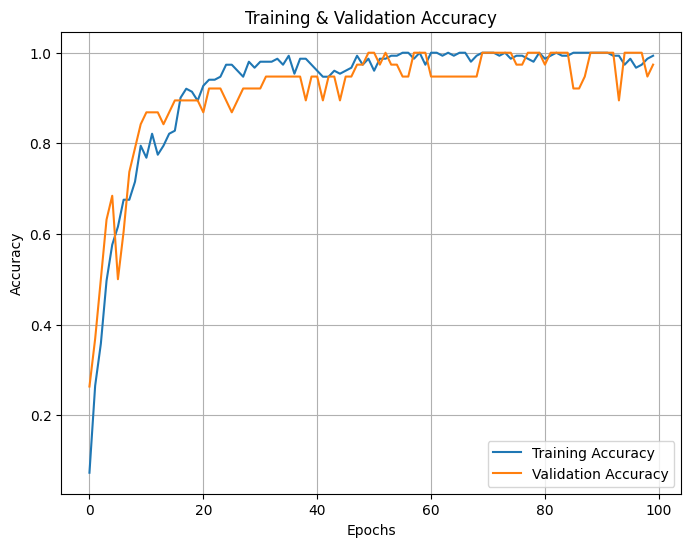

In [49]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [52]:
import pandas as pd
import numpy as np

def load_and_prepare_test_data(csv_le):
    # Load data from CSV

    data = pd.read_csv(csv_le, header=None)


    # Convert to NumPy array for efficient processing
    data = data.values
    data.shape

    # Separate X (features) and Y (first column as labels)
    Y_test = data[:, 0]  # First column as labels
    print(Y_test.shape)
    X_test = data[:, 1:]
    print(X_test.shape) # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_test_seq, Y_test_seq = [], []
    num_sequences = len(X_test) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_test_seq.append(X_test[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_test_seq.append(Y_test[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_test_seq = np.array(X_test_seq)  # Shape: (num_sequences, 25, 84)
    Y_test_seq = np.array(Y_test_seq)  # Shape: (num_sequences,)

    return X_test_seq, Y_test_seq

# Example usage
csv_le = "/content/test.csv"  # Replace with actual path
X_test_seq, Y_test_seq = load_and_prepare_test_data(csv_le)
print("X shape:", X_test_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_test_seq.shape)  # Expected: (num_sequences,)


(25,)
(25, 84)
X shape: (1, 25, 84)
Y shape: (1,)


In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

print(f"✅ Preprocessed Data Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")

,Y,0.1915422885572139,0.1815920398009950,0.0796019900497512,0.1343283582089552,-0.0174129353233831,0.0696517412935323,-0.0696517412935323,0.0273631840796020,-0.0497512437810945,...,-0.1766169154228856,-0.3805970149253731,-0.3855721393034826,-0.4203980099502487,-0.4004975124378110,-0.4676616915422885,-0.3159203980099503,-0.3880597014925373,-0.2512437810945274,-0.3333333333333333
0,Y,0.189591,0.177200,0.080545,0.132590,-0.016109,0.068154,-0.065675,0.030979,-0.050805,...,-0.177200,-0.382900,-0.382900,-0.420074,-0.400248,-0.472119,-0.315985,-0.390335,-0.251549,-0.333333
1,Y,0.189591,0.182156,0.083024,0.135068,-0.013631,0.070632,-0.065675,0.030979,-0.053284,...,-0.179678,-0.382900,-0.385378,-0.422553,-0.397770,-0.474597,-0.315985,-0.392813,-0.254027,-0.335812
2,Y,0.190594,0.188119,0.079208,0.141089,-0.019802,0.076733,-0.071782,0.034653,-0.061881,...,-0.180693,-0.391089,-0.388614,-0.425743,-0.400990,-0.477723,-0.319307,-0.396040,-0.257426,-0.341584
3,Y,0.186104,0.186104,0.081886,0.146402,-0.009926,0.081886,-0.062035,0.044665,-0.049628,...,-0.176179,-0.389578,-0.379653,-0.421836,-0.397022,-0.473945,-0.312655,-0.394541,-0.250620,-0.339950
4,Y,0.188656,0.188656,0.080148,0.144266,-0.016030,0.082614,-0.067818,0.045623,-0.055487,...,-0.176326,-0.395808,-0.378545,-0.427867,-0.395808,-0.479655,-0.311961,-0.398274,-0.250308,-0.344020
5,Y,0.183395,0.189591,0.074349,0.149938,-0.017348,0.087980,-0.066914,0.048327,-0.052045,...,-0.173482,-0.395291,-0.379182,-0.427509,-0.394052,-0.482032,-0.312268,-0.397770,-0.252788,-0.338290
6,Y,0.185049,0.193627,0.079657,0.147059,-0.013480,0.083333,-0.064951,0.056373,-0.064951,...,-0.177696,-0.397059,-0.378676,-0.431373,-0.390931,-0.482843,-0.307598,-0.401961,-0.248775,-0.348039
7,Y,0.184242,0.195152,0.080000,0.151515,-0.012121,0.086061,-0.060606,0.056970,-0.050909,...,-0.172121,-0.401212,-0.370909,-0.435152,-0.387879,-0.488485,-0.305455,-0.408485,-0.247273,-0.352727
8,Y,0.188024,0.202395,0.073054,0.156886,-0.022754,0.092216,-0.073054,0.058683,-0.063473,...,-0.176048,-0.415569,-0.372455,-0.441916,-0.389222,-0.499401,-0.307784,-0.420359,-0.247904,-0.362874
9,Y,0.187351,0.205251,0.075179,0.157518,-0.017900,0.095465,-0.075179,0.066826,-0.072792,...,-0.177804,-0.415274,-0.371122,-0.448687,-0.387828,-0.503580,-0.309069,-0.424821,-0.249403,-0.367542


In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def load_and_prepare_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path, header=None)

    # Convert to NumPy array for efficient processing
    data = data.values

    # Separate X (features) and Y (first column as labels)
    Y = data[:, 0]  # First column as labels
    X = data[:, 1:]  # All other columns as features (shape: num_samples, 84)

    # Define sequence length
    sequence_length = 25

    # Prepare sequences
    X_seq, Y_seq = [], []
    num_sequences = len(X) // sequence_length

    for i in range(num_sequences):
        start_idx = i * sequence_length
        X_seq.append(X[start_idx:start_idx + sequence_length])  # 25 rows of features
        Y_seq.append(Y[start_idx])  # First column value corresponding to the sequence

    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # Shape: (num_sequences, 25, 84)
    Y_seq = np.array(Y_seq)  # Shape: (num_sequences,)

    return X_seq, Y_seq

# Example usage
csv_path = "/content/Double Handed Gestures 20th March.csv"  # Replace with actual path
X_seq, Y_seq = load_and_prepare_data(csv_path)
print("X shape:", X_seq.shape)  # Expected: (num_sequences, 25, 84)
print("Y shape:", Y_seq.shape)  # Expected: (num_sequences,)

# Encode Y_seq (convert string labels to integers)
label_encoder = LabelEncoder()
Y_seq = label_encoder.fit_transform(Y_seq)

num_classes = len(label_encoder.classes_)  # Number of unique classes
Y_seq = to_categorical(Y_seq, num_classes)

X_seq.astype('float32')
# Y_seq.dtype


X shape: (189, 25, 84)
Y shape: (189,)


dtype('float64')

(189, 18)

In [64]:
# Define LSTM model
def create_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(25, 84)),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, test_index in kf.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = Y_seq[train_index], Y_seq[test_index]
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    model = create_model()
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)

print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0343 - loss: 2.9015
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1794 - loss: 2.7642
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2357 - loss: 2.6727
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2872 - loss: 2.5542
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3581 - loss: 2.4246
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4480 - loss: 2.2820
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4584 - loss: 2.1527
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4963 - loss: 1.9617
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5099 - loss: 1.8517
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6350 - loss: 1.6334
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5616 - loss: 1.5860
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6670 - loss: 1.3303
Epoch 13/20
